# IFT 6760A - Homework 1 - Practical part

## Part 0: required packages

This homework should be done in python 3 using this notebook. If you do not have python installed on your machine, then the [Anaconda distribution](https://www.anaconda.com/distribution/) is the way to go (make sure to choose the 3.7 version). This distribution contains most of the commonly used packages.  

You will also need the `tensorly` extra packages (which you can install easily through pip: `pip install tensorly` from the command line).

Run the cell below to make sure you have all the right packages installed.

In [1]:
import numpy as np
import pylab as plt
import scipy.sparse.linalg 
import PIL.Image
import tensorly as tl

## Part I: The magical `einsum`function

*Einstein notation* is a convenient way to lighten mathematical expressions involving summations and relies on the simple convention that indices appearing twice in an expression are summed over (this is actually a naive simplification where we omit the distinction between so-called _covariant_ and _contravariant_ indices). 

For example, the inner product between two vectors $u$ and $v$ is written as
$$u_iv_i := \sum_i u_iv_i.$$

When an index appears only once, it corresponds to free indices of the resulting tensor. For example $A_{ik}B_{kj}$ has two free indices, $i$ and $j$, and thus corresponds to a second-tensor~(aka matrix) whose components $(i,j)$ is given by $\sum_k A_{ik}B_{kj}$ (aka the matrix product of $A$ and $B$). Similarly, the outer product of two vectors $u$ and $v$ is noted $u_iv_j$.


The `einsum` function from the numpy package is inspried from this convention and makes it easy to write contractions between tensors. The function uses *signature* strings to specify contractions between tensors. For example, `'ij,jk->ki'` denotes a contraction between two 2nd-order tensors~(i.e., matrices $A$ and $B$), the indices of the first one are $i$ and $j$ and the indices of the second one are $j$ and $k$. Since $j$ appears twice it is summed over and the indices appearing after the right arrow `->` specify the order of the indices in the resulting tensor. Thus, `'ij,jk->ki'` corresponds to $(AB)^\top$.

More precisely, a signature strings is interpreted using these two simple rules:

- if an index appears in several input arrays, it means that the corresponding modes (are axes in numpy terminology) should be mutliplied together
- if an index appears at the left of the arrow sign `->` but not at the right, it means that is should be summed over


Here are a couple examples (`u`, `v` and `w` are numpy 1d arrays, `A` and `B` are two 2d arrays and `T` is a 3d array):

- inner product: `np.einsum('i,i->',u,v)`
- outer product: `np.einsum('i,j->ij',u,v)`
- outer product between three vectors: `np.einsum('i,j,k->ijk',u,v,w)`
- "3-way contraction" between three vectors: `np.einsum('i,i,i->',u,v,w)`
- sum of elements of a vector: `np.einsum('i->')
- transpose: `np.einsum('ij->ji',A)`
- trace of a matrix: `np.einsum('ii->',A)`
- diagonal of a matrix: `np.einsum('ii->i',A)`
- element-wise multiplication of two matrices: `np.einsum('ij,ij->ij',A,B)`
- sum of the product of the diagonal elements of two matrices: `np.einsum('ii,ii->',A,B)`
- mode-2 product: `np.einsum('ijk,lj->ilk',T,A)`




**Exercise**

Write the following functions with only one line using the `einsum` function:

In [13]:
from numpy import einsum

def inner_product(S,T):
    """
    S,T: two tensors of order 3
    returns the inner product between the two
    """
    return einsum('ijk,ijk->', S,T)

def tucker_to_tensor(G,A,B,C):
    """
    G: 3rd order core tensor 
    A,B,C: factor matrices
    
    returns the tensor with Tucker decomposition $$G \times_1 A \times_2 B \times_3 C$$
    """
    return einsum('ijk,lk->ijl',einsum('ijk,lj->ilk', einsum('ijk,li->ljk',G,A), B), C)

def cp_to_tensor(A,B,C):
    """
    A,B,C: factor matrices (same number of columns in each)
    
    returns the tensor with CP decomposition $$[[A,B,C]]$$
    """
    return einsum('iz,jz,kz->ijk',A,B,C)

def tt_to_tensor(A,B,C,D):
    """
    A,B,C,D: core tensors (A and D are order 2, and B and C are order 3)
    
    returns the tensor with tensor train decomposition $$<<A,B,C,D>>$$
    """
    return einsum('iu,ujw,wkx,xl->ijkl',A,B,C,D)
    
def tr_to_tensor(A,B,C,D):
    """
    A,B,C,D: core tensors (all of order 3)
    
    returns the tensor with tensor ring decomposition $$((A,B,C,D))$$. Recall that the tensor ring decomposition
    is defined by
    ((A,B,C,D))_{ijkl} = \sum_{r_1,r_2,r_3,r_4} A_{r_1,i,r_2}B_{r_2,i,r_3}C_{r_3,i,r_4}D_{r_4,i,r_1}
    """
    return einsum('xiy,yjz,zkw,wlx->ijkl',A,B,C,D)

Run the following cell to check whether your implementation of these functions is correct:

In [14]:


G = tl.tensor(np.random.normal(0,1,[10,11,12]))
T = tl.tensor(np.random.normal(0,1,[10,11,12]))
A,B,C = [np.random.normal(0,1, [d,4]) for d in [10,11,12]]
D,E,F = [np.random.normal(0,1, [d,r]) for d,r in zip([15,15,14],[10,11,12])]
G1,G2,G3,G4 = [np.random.normal(0,1, [r1,d,r2]) for r1,d,r2 in zip([3,4,5,6],[9,8,7,8],[4,5,6,3])]


try:
    print("inner_product: ok" if np.allclose(tl.tenalg.inner(G,T), inner_product(G,T)) else "inner_product: failed")
except Exception as e:
    print("inner_product: exception raised \n",e)
print()                
try:
    print("tucker_to_tensor: ok" if np.allclose(tl.tucker_to_tensor((G,[D,E,F])), tucker_to_tensor(G,D,E,F)) else "tucker_to_tensor: failed")
except Exception as e:
    print("tucker_to_tensor: exception raised \n",e)
print() 
try:
    print("cp_to_tensor: ok" if np.allclose(tl.kruskal_to_tensor((np.ones(4),(A,B,C))), cp_to_tensor(A,B,C)) else "cp_to_tensor: failed")
except Exception as e:
    print("cp_to_tensor: exception raised \n",e)
print() 
try:
    print("tt_to_tensor: ok" if np.allclose(tl.mps_to_tensor((G1[:1,:,:],G2,G3,G4[:,:,:1])), tt_to_tensor(G1[0,:,:],G2,G3,G4[:,:,0])) else "tt_to_tensor: failed")
except Exception as e:
    print("tt_to_tensor: exception raised \n",e)
print() 
try:
    print("tr_to_tensor: ok" if np.allclose(sum([tl.mps_to_tensor([G1[i:i+1,:,:],G2,G3,G4[:,:,i:i+1]]) for i in range(3)]), tr_to_tensor(G1,G2,G3,G4)) else "tr_to_tensor: failed")
except Exception as e:
    print("tr_to_tensor: exception raised \n",e)    


inner_product: ok

tucker_to_tensor: ok

cp_to_tensor: ok

tt_to_tensor: ok

tr_to_tensor: ok


## Part II: Alternating Least Squares and Gradient Descent for the CP Decomposition

In this first part of the homework, you will compare two optimization algorithms to compute approximate solutions for the problem of approximating a tensor using the CP decomposition: Alternating Least Squares and Gradient Descent.

For a given tensor $T$ of size $d_1\times d_2 \times d_3$ and a target rank $R$, the low rank CP decomposition problem can be formulated as follows:

$${\arg\min}_{A\in \mathbb{R}^{d_1\times R},B\in \mathbb{R}^{d_2\times R}, C\in \mathbb{R}^{d_3\times R}} \| T - [\!| A,B,C |\!]\|_{F}^2$$
where $[\!| A,B,C |\!]$ denotes the CP decomposition with factor matrices $A,B$ and $C$.


**Question** Start by implementing ALS by filling the code skeleton below. To reconstruct a CP tensor from the 3 factor matrices $A,B,C$, use the function cp_to_tensor you wrote in the previous question.


In [101]:


def khatri_rao(A,B):
    assert A.shape[1] == B.shape[1], "A and B must have the same number of columns. A={0}, B={1}".format(A.shape,B.shape)
    return np.einsum('ir,jr->jir',A,B).reshape(A.shape[0]*B.shape[0],A.shape[1])


def CP_ALS(T, rank, epsilon=1e-5,max_iters=100,verbose=True,errors_at_iterations=[]):
    # Initialize A, B and C
    # YOUR CODE HERE
    A = np.random.rand(T.shape[0],rank)
    B = np.random.rand(T.shape[1],rank)
    C = np.random.rand(T.shape[2],rank)
    T_approx_old = cp_to_tensor(A,B,C)#tl.kruskal_to_tensor((np.ones(rank),[A,B,C]))
    it = 1
    while True: # repeat until convergence
        # update the factor matrices A, B and C. Here are a couple of indications:
        # - to efficiently solve a least square problem you can use numpy.lstsq
        # - matricizations (unfolding) of T can be obtained using tl.unfold
        # - to compute the Khatri-Rao product use the function khatri_rao defined above
        # YOUR CODE HERE
        #A = tl.unfold(T,0)@(khatri_rao(C,B))@np.linalg.pinv(C.T@C@B.T@B)
        #B = tl.unfold(T,1)@(khatri_rao(C,A))@np.linalg.pinv(C.T@C@A.T@A)
        #C = tl.unfold(T,2)@(khatri_rao(B,A))@np.linalg.pinv(B.T@B@A.T@A)
        
        A = np.linalg.lstsq(khatri_rao(C,B),tl.unfold(T,0).T)[0].T
        B = np.linalg.lstsq(khatri_rao(C,A),tl.unfold(T,1).T)[0].T
        C = np.linalg.lstsq(khatri_rao(B,A),tl.unfold(T,2).T)[0].T
        # check for convergence:
        T_approx_new = cp_to_tensor(A,B,C)#tl.kruskal_to_tensor((np.ones(rank),[A,B,C]))
        reconstruction_error =  tl.norm(T_approx_new-T)
        errors_at_iterations.append(reconstruction_error)        
        if tl.norm(T_approx_old - T_approx_new)/tl.norm(T_approx_old) < epsilon or it > max_iters:
            return (A,B,C)
        if verbose:
            print(it, " - reconstruction error: ",reconstruction_error, "convergence: ", tl.norm(T_approx_old - T_approx_new)/tl.norm(T_approx_old))

        
        T_approx_old = T_approx_new
        it += 1
        



**Question** Plot the reconstruction error as a function of the iterations for 10 different initialization for ALS to find an approximate CP decomposition of the tensor T below of rank 2. Plot all the curves in the same figure and use a maximum number of iterations of 100. Observations?

/home/beast/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/beast/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/beast/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass 

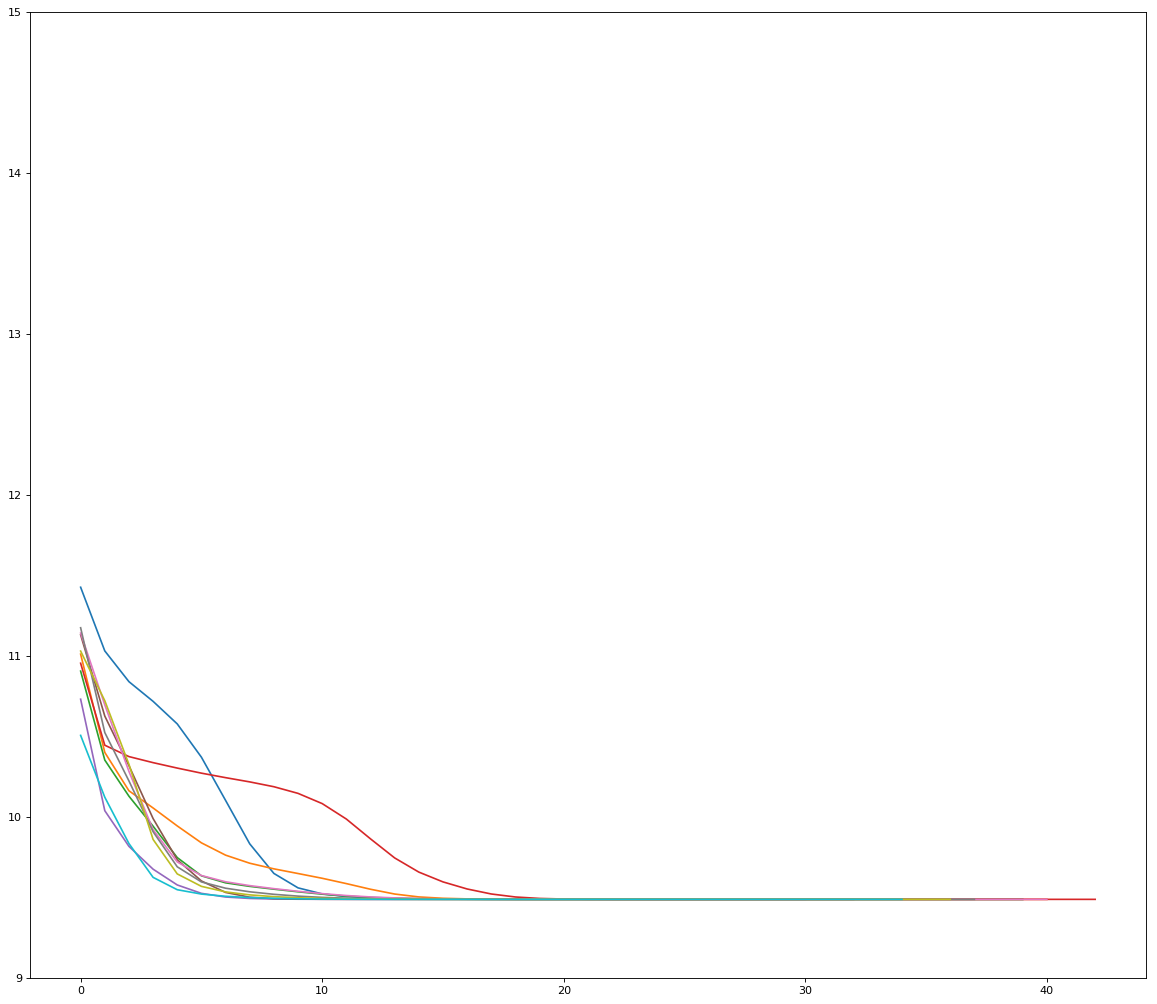

In [116]:


T = tl.tensor(np.random.normal(0,1,[5,10,3]))
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
# - to plot a curve, use the plt.plot function
# - once all plt.plot functions have been run, use plt.show() to show the figure
# - to recover the errors at each iteration, you can use the following code:
errors = []
# CP_ALS(...[other arguments here]..., errors_at_iterations=errors)
# - when the method CP_ALS returns, errors while be a list containing the error at each iteration
# YOUR CODE HERE
all_errors = []
results = []
plt.ylim(9, 15)
for i in range(10):
    results.append(CP_ALS(T, 2,verbose=False,errors_at_iterations=errors))
    #plt.subplot(1,2,1)
    plt.plot(range(len(errors)),errors)
    errors = []
    
#plt.subplot(1,2,2)
#plt.plot(range(len(results)),results)
plt.show()

*Write your observations in this cell*

... ... ...


**Question** Now take inspiration from the CP_ALS function you wrote above to implement gradient descent to solve the CP low rank approximation problem.

In [ ]:
def CP_GD(T, rank, epsilon=1e-5,max_iters=100,lr=1e-2,verbose=True,errors_at_iterations=[]):
    # Initialize A, B and C
    # YOUR CODE HERE
    
    
    T_approx_old = # YOUR CODE HERE #
    it = 1
    while True: # repeat until convergence
        # compute gradients wrt A B and C and do a gradient step
        # YOUR CODE HERE
        
        
        # check for convergence:
        T_approx_new = # YOUR CODE HERE #
        reconstruction_error =  # YOUR CODE HERE #
        errors_at_iterations.append(reconstruction_error)
        
                
        if tl.norm(T_approx_old - T_approx_new)/tl.norm(T_approx_old) < epsilon or it > max_iters:
            return (A,B,C)
        if verbose:
            print(it, " - reconstruction error: ",reconstruction_error, "convergence: ", tl.norm(T_approx_old - T_approx_new)/tl.norm(T_approx_old))
        
        T_approx_old = T_approx_new
        it += 1
        


**Question** Plot the reconstruction error as a function of the iterations for 10 different initialization of ALS and 10 initializations of gradient descent to find an approximate CP decomposition of the tensor T below of rank 2. Plot all the curves in the same figure and use a maximum number of iterations of 100. Observations?

In [ ]:


T = tl.tensor(np.random.normal(0,1,[5,10,3]))

### YOUR CODE HERE
    


*Write your observations in this cell*

... ... ...


## Part III: Image Compression with Matrix and Tensor Factorization

In this part of the homework you will compare 5 different ways to compress an image using matrix and tensor factorization techniques:

- SVD
- CP decomposition
- Tucker decomposition 
- Tensor Train decomposition
- Tensor Train decomposition with reshaping to high-order tensor

For the tensor decomposition methods, we will use the `tensorly` python package.




We will use two images as example for this part of the homework: an image of a building, and a of a racoon. Run the cell below to see the two images. Note that those images are color images, thus they are tensors of order 3 (`width`$\times$ `height`$\times 3$).

In [ ]:
!wget -nc https://www-labs.iro.umontreal.ca/~grabus/files/building2.jpg
!wget -nc https://www-labs.iro.umontreal.ca/~grabus/files/racoon.jpg


image1 = tl.tensor(np.array(PIL.Image.open('building2.jpg')), dtype='float64')/255
image2 = tl.tensor(np.array(PIL.Image.open('racoon.jpg')), dtype='float64')/255

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
imshow(image1)
plt.title("building.jpg")

plt.subplot(1,2,2)
imshow(image2)
plt.title("racoon.jpg")
    
plt.show()

**Question** First you will use a simple low rank approximation with SVD. For this you will first unfold the image/tensor into a matrix of shape `width`$\times 3$`height`) and then perform trunated SVD usimg the `svds` function from the `scipy.sparse.linalg` pakcage.

Complete the code skeleton below.

In [ ]:
from scipy.sparse.linalg import svds

def svd_compression(image, rank):
    """
    image is a third order tensor of shape width x height x 3
    rank is the rank of the truncated SVD
    
    This function should return an order 3 tensor of shape width x height x 3 corresponding to the initial 
    tensor compressed using truncated SVD on the appropriate matricization/unfolding 
    """
    # - Recall that unfolding a tensor can be done with the tl.unfold function
    # - The inverse operation (i.e., reconstructing a tensor from an unfolding/matricization) can be done
    # with the tl.fold function.
    
    ### YOUR CODE HERE
    

**Question** Complete the code skeleton below to write a function that returns the compression ratio achieved by truncated SVD for a given input image and target rank. The compression ratio is given by the number of parameters of the low rank factorization divided by the number of parameters in the orginal image. *You should not count the size of the diagonal matrix of singular values in this computation since it can be incorporated in one of the matrices of singular vectors*.

At the end of the cell, a test will let you know whether your implementation is correct.

In [ ]:
def svd_compress_ratio(image, rank):
    """
    This function should return the compression ratio achieved by truncated SVD on the input image
    using the input rank.
    Note: this function *should not call the svd_compression function you wrote previously*, it should computes
    the compression ratio using the size of the image, the rank, and your knowledge of the SVD.
    """
    ### YOUR CODE HERE
    
    
    

try:
    image = np.zeros([200,300,3])
    print("test passed" if svd_compress_ratio(image,3)== 3300/(200*300*3) else "test failed")
except Exception as e:
    print("exception raised \n",e)



Run the cell below to see the compressed images using different values for the rank of the truncated SVD.

In [ ]:
plt.figure(figsize=(20,12))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+1)
    imshow(svd_compression(image1,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,svd_compress_ratio(image1,rank)*100))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+4)
    imshow(svd_compression(image2,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,svd_compress_ratio(image2,rank)*100))
    
plt.show()

Now you will use a CP decomposition. For this, you will use the function `cp_decomposition` defined below. To reconstruct a tensor from the factor matrices, use the function `cp_to_tensor` you wrote in the previous question.

Similarly to truncated SVD, you need to write a function which returns the number of parameters of a CP decomposition (a simple test is executed at the end of the celle to check that your implementation is correct).

**Question** Complete the code skeleton below.

In [ ]:
from tensorly.decomposition import parafac

def cp_decomposition(tensor, rank):
    (weights,factors) = parafac(tensor, rank=rank, init='random', tol=10e-6)
    L = [factors[0]@np.diag(weights)] + factors[1:]
    return L


def cp_compression(image, rank):
    """
    image is a third order tensor of shape width x height x 3
    rank is the rank of the CP decomposition
    
    This function should return an order 3 tensor of shape width x height x 3 corresponding to the initial 
    tensor compressed using CP decomposition
    """
    ### YOUR CODE HERE
    
    
    
def cp_compress_ratio(image, rank):
    """
    This function should return the compression ratio achieved by CP on the input image
    using the input rank.
    Note: this function *should not call the cp_compression function you wrote previously*, it should computes
    the compression ratio using the size of the image, the rank, and your knowledge of the definition of the 
    CP decomposition.
    """
    ### YOUR CODE HERE
    


try:
    image = np.zeros([200,300,3])
    print("test passed" if cp_compress_ratio(image,4)== 2012/(200*300*3) else "test failed")
except Exception as e:
    print("exception raised \n",e)




Run the cell below to see the compressed images using different values for the rank of the CP decomposition.

In [ ]:
plt.figure(figsize=(20,12))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+1)
    imshow(cp_compression(image1,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,cp_compress_ratio(image1,rank)*100))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+4)
    imshow(cp_compression(image2,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,cp_compress_ratio(image2,rank)*100))
    
plt.show()

**Question** Now you will use a Tucker decomposition. Use the function `tucker` from the `tensorly` package  and the function `tucker_to_tensor` to fill in the code skeleton below. 

For the rank parameter, we will use a unform rank for the two first modes of the decomposition and use 3 for the rank of the 3rd mode of the decomposition. E.g., if the rank argument is 10, the Tucker decomposition should be of rank (10,10,3).

As before, you need to write a function which returns the number of parameters of a Tucker decomposition (a simple test is executed at the end of the celle to check that your implementation is correct).


In [ ]:
from tensorly.decomposition import tucker

def tucker_compression(image, rank):
    """
    image is a third order tensor of shape width x height x 3
    rank is the rank of the Tucker decomposition for the first two modes, the third rank should be 3 
    (i.e., the Tucker rank of the tucker_decomposition is (rank,rank,3))
    
    This function should return an order 3 tensor of shape width x height x 3 corresponding to the initial 
    tensor compressed using Tucker decomposition
    """
    ### YOUR CODE HERE
    
    
    
def tucker_compress_ratio(image, rank):
    """
    This function should return the compression ratio achieved by Tucker on the input image
    using the input rank.
    Note 1: this function *should not call the tucker_compression function you wrote previously*, it should computes
    the compression ratio using the size of the image, the rank, and your knowledge of the definition of the 
    Tucker decomposition.
    """
    ### YOUR CODE HERE
    


try:
    image = np.zeros([200,300,3])
    print("test passed" if tucker_compress_ratio(image,4)== 2060/(200*300*3) else "test failed")
except Exception as e:
    print("exception raised \n",e)



Run the cell below to see the compressed images using different values for the rank of the Tucker decomposition.

In [ ]:
plt.figure(figsize=(20,12))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+1)
    imshow(tucker_compression(image1,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,tucker_compress_ratio(image1,rank)*100))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+4)
    imshow(tucker_compression(image2,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,tucker_compress_ratio(image2,rank)*100))
    
plt.show()

**Question** Now you will use a TT decomposition. Use the function `matrix_product_states` and `mps_to_tensor` from the `tensorly` package to fill in the code skeleton below. As before, you need to write a function which returns the number of parameters of a TT decomposition (a simple test is executed at the end of the celle to check that your implementation is correct).


In [ ]:
from tensorly.decomposition import matrix_product_state
from tensorly import mps_to_tensor

def tt_compression(image, rank):
    """
    image is a third order tensor of shape width x height x 3
    rank is the rank of the TT decomposition (i.e., the TT rank of the TT_decomposition is (rank,rank,...,rank))
    
    This function should return an order 3 tensor of shape width x height x 3 corresponding to the initial 
    tensor compressed using TT decomposition
    """
    ### YOUR CODE HERE
    
    
    
def tt_compress_ratio(image, rank):
    """
    This function should return the compression ratio achieved by TT on the input image
    using the input rank.
    Note 1: this function *should not call the tt_compression function you wrote previously*, it should computes
    the compression ratio using the size of the image, the rank, and your knowledge of the definition of the 
    TT decomposition.
    Note 2: remember that the ranks of a TT decomposition are bounded by the dimension of some 
    unfolding/matricizations of the input tensor. You need to take this into account in your computations!
    """
    ### YOUR CODE HERE
    


try:
    image = np.zeros([200,300,3])
    print("test passed" if tt_compress_ratio(image,4)== 4409/(200*300*3) else "test failed")
except Exception as e:
    print("exception raised \n",e)



Run the cell below to see the compressed images using different values for the rank of the TT decomposition.

In [ ]:
plt.figure(figsize=(20,12))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+1)
    imshow(tt_compression(image1,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,tt_compress_ratio(image1,rank)*100))
for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+4)
    imshow(tt_compression(image2,rank))
    plt.title("rank:%i - compression: %.2f%%" %(rank,tt_compress_ratio(image2,rank)*100))
    
plt.show()

To conclude this homework, we will see a last decomposition technique where we reshape the input image into a high order tensor before applying TT decomposition for the compression.

For this we will implement a particular way of reshaping a tensor which takes into account the local correlation in images. The technique is borrowed from https://arxiv.org/abs/1807.01589:

*The idea is simple, if the
size of a RGB image is U ×V ×3, and U = u1×u2×· · ·×ul
and V = v1 × v2 × · · · × vl are satisfied, then the image
can be tensorized to a (l + 1)-dimension tensor of size
u1v1 × u2v2 × · · · × ulvl × 3. The first dimension of the
higher-dimension tensor stands for a pixel block of the image,
and the following dimensions are the extension blocks of the
image. The higher-dimension tensor generated by the above
tensorization scheme is considered to be a better structure of
the image.*

**Question** Write two functions: 
- one that takes an image as input with a list of dimensions to factorize the rows and a list of dimensions to factorize the columns, and returns the tensor obtained by reshaping the image using the scheme described above.
- a second that implements the reverse operation. 

Note that to properly implement this function, you need to first reshape the image into u1 × u2× ... × ul x v1 × v2 × ... × vl x 3, then transpose the tensor into shape u1 x v1 x u2 x v2 x ... x ul x vl x 3, before finally reshaping into shape u1v1 × u2v2 × · · · × ulvl × 3

In [ ]:
def reshape_image_to_tensor(img, dims_rows, dims_cols):
    """
    img: a 3rd order tensor of shape width x height x 3
    dims_rows: a list of dimension u1,u2,...,ul such that width=u1u2...ul
    dims_cols: a list of dimension v1,v2,...,vl such that width=v1v2...vl
    
    returns a tensor of shape u1v1 x u2v2 x ... x ulvl x 3
    """
    ### YOUR CODE HERE
    

def reshape_tensor_to_image(tensor, dims_rows, dims_cols):
    """
    tensor: a tensor of shape u1v1 x u2v2 x ... x ulvl x 3
    dims_rows: a list of dimension u1,u2,...,ul such that width=u1u2...ul
    dims_cols: a list of dimension v1,v2,...,vl such that width=v1v2...vl
    
    returns a tensor T of shape width x height x 3 such that for an initial image img:
    img = reshape_tensor_to_image(reshape_image_to_tensor(img, dims_rows, dims_cols), dims_rows, dims_cols)
    """
    
    ### YOUR CODE HERE
    


**Question** Now you will use the TT decomposition on the reshaped tensor. Use the function `matrix_product_states` and `mps_to_tensor` from the `tensorly` package as well as the functions `reshape_image_to_tensor` and `reshape_tensor_to_image` you wrote previously to fill in the code skeleton below. As before, you need to write a function which returns the number of parameters of the TT decomposition, on the reshaping (a simple test is executed at the end of the celle to check that your implementation is correct).


In [ ]:
from tensorly.decomposition import matrix_product_state
from tensorly import mps_to_tensor

def tt_reshape_compression(image, rank, dims_rows, dims_cols):
    """
    image is a third order tensor of shape width x height x 3
    rank is the rank of the TT decomposition (i.e., the TT rank of the TT_decomposition is (rank,rank,...,rank))
    dims_rows anddims_cols are the lists of dimensions to use for the reshaping operation discussed above.
    
    This function should return an order 3 tensor of shape width x height x 3 corresponding to the initial 
    tensor compressed using TT decomposition on the reshaping of the image
    """
    ### YOUR CODE HERE
    
def tt_reshape_compress_ratio(image, rank,dims_rows, dims_cols):
    """
    This function should return the compression ratio achieved by TT on the input image
    using the input rank.
    Note 1: this function *should not call the tt_compression function you wrote previously*, it should computes
    the compression ratio using the size of the image, the rank, and your knowledge of the definition of the 
    TT decomposition.
    Note 2: remember that the ranks of a TT decomposition are bounded by the dimension of some 
    unfolding/matricizations of the input tensor. You need to take this into account in your computations!
    """
    ### YOUR CODE HERE

try:
    image = np.zeros([200,300,3])
    print("test passed" if tt_reshape_compress_ratio(image,4,[2,5,20],[3,20,5])== 2833/(200*300*3) else "test failed")
except Exception as e:
    print("exception raised \n",e)



Run the cell below to see the compressed images using different values for the rank of the TT decomposition.

In [ ]:
plt.figure(figsize=(20,12))

for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+1)
    dims_rows,dims_cols=[2,2,2,2,2,2,2,2],[2,2,2,2,2,2,2,2]
    imshow(tt_reshape_compression(image1,rank,dims_rows,dims_cols))
    plt.title("rank:%i - compression: %.2f%%" %(rank,tt_reshape_compress_ratio(image1,rank,dims_rows,dims_cols)*100))

for i,rank in enumerate([2,10,20]):
    plt.subplot(2,3,i+4)
    dims_rows,dims_cols=[2,2,2,2,2,2,2,2],[2,2,2,2,2,2,2,2]
    imshow(tt_reshape_compression(image2,rank,dims_rows,dims_cols))
    plt.title("rank:%i - compression: %.2f%%" %(rank,tt_reshape_compress_ratio(image2,rank,dims_rows,dims_cols)*100))

plt.show()

To conclude, you can run the cell below to compare the various decomposition techniques comparable approximation ratio (change the ratio variable value to compare different ones).

In [ ]:
ratio = 5/100


def compress_ratio(image,method,rank,reshape=None):
    if method=='SVD':
        return svd_compress_ratio(image,rank)
    if method=='CP':
        return cp_compress_ratio(image,rank)
    if method=='TT':
        return tt_compress_ratio(image,rank)
    if method=='TUCKER':
        return tucker_compress_ratio(image,rank)
    if method=='TT_reshape':
        return tt_reshape_compress_ratio(image,rank,reshape[0],reshape[1])
    
def compress(image,method,rank,reshape=None):
    if method=='SVD':
        return svd_compression(image,rank)
    if method=='CP':
        return cp_compression(image,rank)
    if method=='TT':
        return tt_compression(image,rank)
    if method=='TUCKER':
        return tucker_compression(image,rank)
    if method=='TT_reshape':
        return tt_reshape_compression(image,rank,reshape[0],reshape[1])
    
def approx_ratio_to_rank(image,method,target_ratio,reshape=None):
    rank = 1
    while True:
        ratio = compress_ratio(image,method,rank,reshape)
        if ratio > target_ratio:
            return rank-1
        rank += 1
        

def plot_compressed(image,method,rank,reshape=None):
    compressed_img = compress(image,method,rank,reshape)
    plt.imshow(compressed_img)
    plt.title("%s (rank: %i - compress ratio: %.4f)" % (method,rank,compress_ratio(image,method,rank,reshape)))
    return compressed_img
              

plt.figure(figsize=(15,30))

reshape=([2,2,2,2,2,2,2,2],[2,2,2,2,2,2,2,2])
for i,method in enumerate(["SVD","CP","TUCKER","TT","TT_reshape"]):
    plt.subplot(5,2,2*i+1)
    rank = approx_ratio_to_rank(image1,method,ratio,reshape)
    plot_compressed(image1,method,rank,reshape)

for i,method in enumerate(["SVD","CP","TUCKER","TT","TT_reshape"]):
    plt.subplot(5,2,2*i+2)
    rank = approx_ratio_to_rank(image2,method,ratio,reshape)
    plot_compressed(image2,method,rank,reshape)

*Write your observations in this cell (if any)*

... ... ...